In [15]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import os
import sys
import seaborn as sns
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/Pedophysics_code')
sys.path.insert(0, 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code')

from pedophysics import predict, Soil
from statistics import mode
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem
from plots import *
from PM import *
import sys
%matplotlib inline

pd.set_option('display.max_columns', None)
from utils.spatial_utils import utm_to_epsg, get_coincident


# Configure input

In [16]:
# User input
s_site = 'P'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
datafolder = 'Data' # data folder
em_intype = 'LIN'   # 'reca' = rECa EMI data; 'lin' = LIN ECa EMI data; 
cal = 'non_calibrated' # 'non_calibrated'
instrument_code = '21HS' # 421S

## Load data

In [17]:
if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if instrument_code == '21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if instrument_code == 'Dualem-21HS':
        instrument_code = 'Dualem-421S'

cal_folder = os.path.join(datafolder, cal)
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_{cal}_{em_intype}.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')
inv_s = os.path.join(datafolder, f'{profile_prefix}_inverted_samples_21HS.csv')

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
em_survey = pd.read_csv(em_survey, sep=',', header=0)
inverted = pd.read_csv(inv_s, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)
em_samples = get_coincident(em_survey, samples)

print('em_samples', em_samples)

em_samples                  x            y          z         t     HCP0.5     PRP0.6  \
5166   107720.1177  183326.9599  26.190915  40954.67  35.895241  19.478238   
19244  107755.5892  183331.1005  26.895158  42473.18  20.798488   8.568528   
22350  107797.4015  183278.5790  28.470657  42812.37  51.949483  22.530592   
19352  107763.8156  183318.1123  27.344669  42491.37  17.424280   7.430910   
1556   107723.0051  183309.1818  26.586000  40592.63  41.856769  22.675713   
14669  107742.6515  183330.2073  26.664000  41906.95  26.164820  12.390289   
23383  107805.8221  183273.9873  28.650000  42915.67  50.435374  19.463452   
15706  107758.6852  183312.6012  27.350000  42107.27  20.302663   9.840766   
22198  107776.6922  183310.7557  27.551037  42797.16  31.980251  11.556375   
5128   107726.3707  183318.7191  26.563000  40950.86  44.695284  22.978307   
5166   107720.1177  183326.9599  26.190915  40954.67  35.895241  19.478238   
19244  107755.5892  183331.1005  26.895158  42473.18 

# Data Analysis
### Data wrangling

In [18]:
ds_c = em_samples.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

ds_c['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds_c.bulk_ec_hp.values))

ds_c['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds_c.bulk_ec_hp, ds_c.temp)
ds_c['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values,
                                                    bulk_ec_dc = ds_c.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

In [19]:
inv_columns = inverted.columns[3:-1]
ds_c[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(inverted.x)):
        ds_c.loc[ds_c.code == i+1, c] = inverted.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

# Apply the function to each row
ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds_c.bulk_ec_inv.values/1000))*1000

ds_c.to_csv('ds_c.csv')
#print(ds_c)

### Correlations

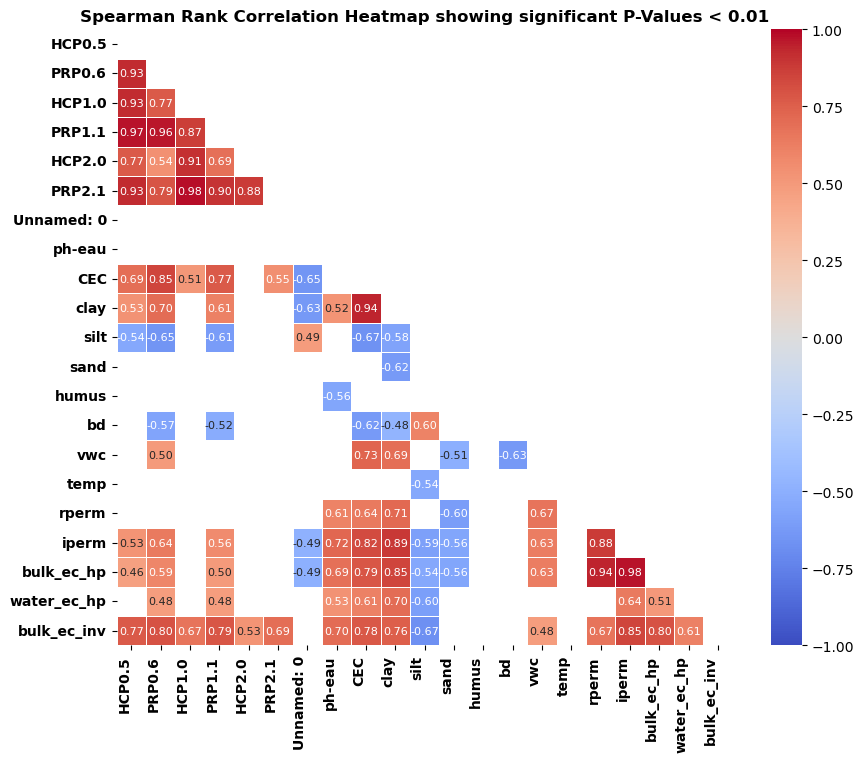

<Figure size 640x480 with 0 Axes>

In [20]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in ds_c.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(ds_c[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.01
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot
plt.show()

filename = f"Corr_{s_site}_{cal}_{em_intype}.png"
#plt.savefig(filename)



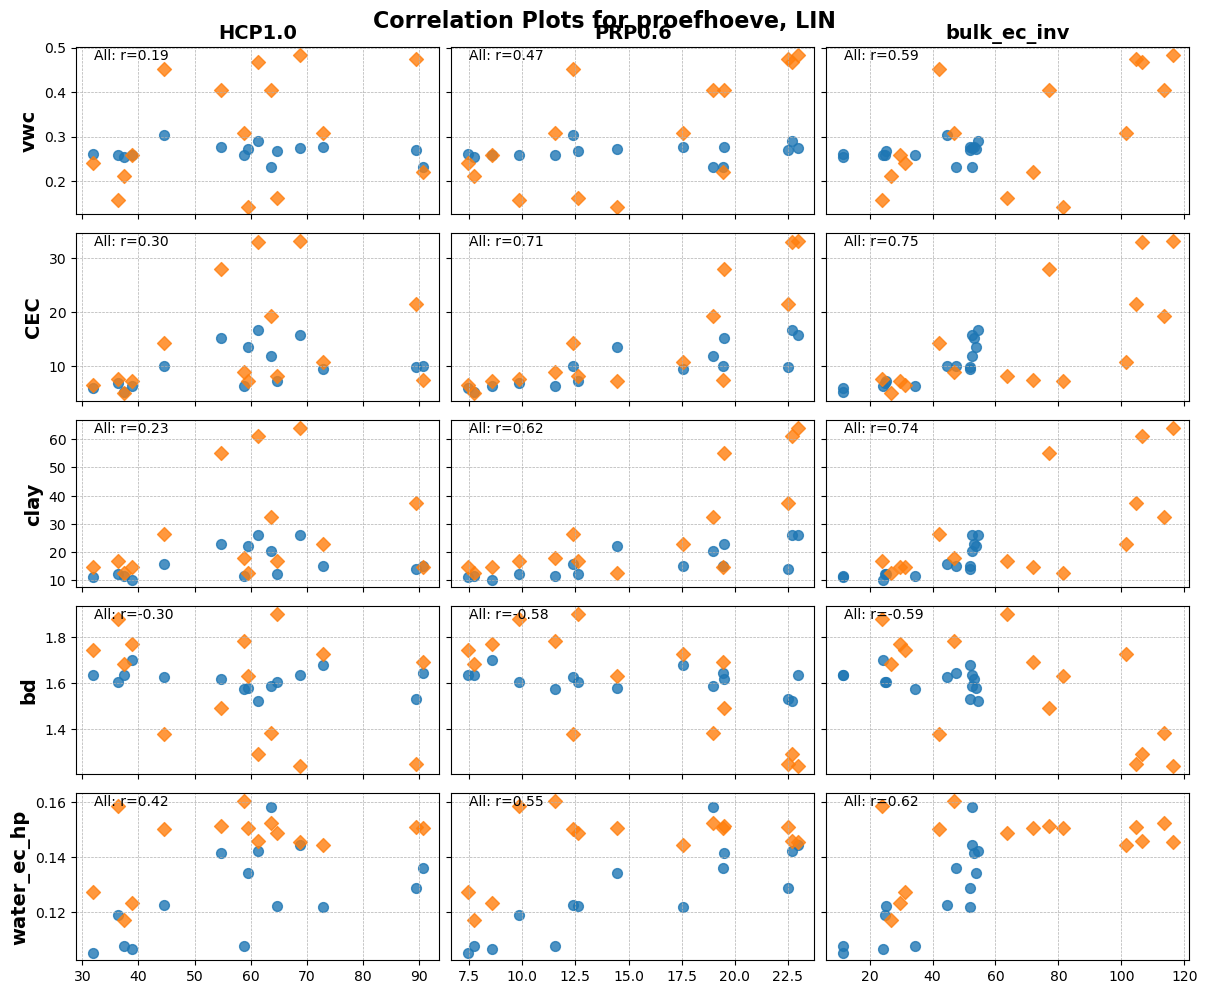

<Figure size 640x480 with 0 Axes>

In [21]:
fig, axes = plt.subplots(5, 3, figsize=(12, 10))
ss = 50  # Reduced size for scatter points

preds = ['HCP1.0', 'PRP0.6', 'bulk_ec_inv']

def corr_plot(df, preds, targets):
    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):
            ax = axes[target_index, pred_index]
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')

            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:
                ax.set_xticklabels([])

            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:
                ax.set_yticklabels([])

corr_plot(ds_c, preds, ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp'])
plt.suptitle(f"Correlation Plots for {profile_prefix}, {em_intype}", fontweight='bold', fontsize=16)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

filename = f"Plot_{s_site}_{cal}_{em_intype}.png"
#plt.savefig(filename)

# Deterministic modelling

## Implementation

In [22]:
clay_50cm = np.mean(ds_c.clay[ds_c['depth']==50])
clay_10cm = np.mean(ds_c.clay[ds_c['depth']==10])
bd_50cm = np.mean(ds_c.bd[ds_c['depth']==50])
bd_10cm = np.mean(ds_c.bd[ds_c['depth']==10])
water_ec_hp_50cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==50])
water_ec_hp_10cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==10])
clay_mean = np.mean(ds_c.clay)
bd_mean = np.mean(ds_c.bd)
water_ec_hp_mean = np.mean(ds_c.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_c.water_ec_hp_t)
temp_50cm = np.mean(ds_c.temp[ds_c['depth']==50])
temp_10cm = np.mean(ds_c.temp[ds_c['depth']==10])
temp_mean = np.mean(ds_c.temp)
vwc_50cm = np.mean(ds_c.vwc[ds_c['depth']==50])
vwc_10cm = np.mean(ds_c.vwc[ds_c['depth']==10])
vwc_mean = np.mean(ds_c.vwc)

feature_set = [
    'HCP0.5',
    'HCP1.0',
    'HCP2.0',
#    'HCP4.0',
    'PRP0.6',
    'PRP1.1',
    'PRP2.1',
#    'PRP4.1',
    'bulk_ec_inv',
#    'bulk_ec_dc_tc_inv',
#    'bulk_ec_hp',
#    'bulk_ec_dc_tc_hp'
]

In [23]:
def deterministic(feature, target, df, iters=100, round_n=3):
    df.reset_index(drop=True, inplace=True)
    DR2_LS, DRMSE_LS = [], []
    DR2_LT, DRMSE_LT = [], []
    DR2_10, DRMSE_10 = [], []
    DR2_50, DRMSE_50 = [], []
    DR2_ID, DRMSE_ID, ypred_ID_ = [], [], []
    y_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, feature].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, feature].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    f_ec = 9000
    t_conv = 273.15

    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10, idx_train10, idx_test10 = train_test_split(X_layer_10, Y_layer_10, idx_layer_10, test_size=0.3, random_state=i)
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50, idx_train50, idx_test50 = train_test_split(X_layer_50, Y_layer_50, idx_layer_50, test_size=0.3, random_state=i)

        ### Combine test indices from both layers
        idx_test = np.concatenate((idx_test10, idx_test50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_.append(y_test)

        ### Predict using layer together 
        LT = Soil( 
                    bulk_ec = X_test,
                    frequency_ec=f_ec,
                    clay = clay_mean,
                    bulk_density = bd_mean,
                    water_ec = water_ec_hp_mean,
                    temperature = temp_mean+t_conv
                      )
        Dypred_LT = predict.Water(LT)
        DR2_LT.append(round(r2_score(y_test, Dypred_LT), round_n))
        DRMSE_LT.append(round(RMSE(y_test, Dypred_LT), round_n))

        ### Predict using 10 cm layer
        layer_10 = Soil( 
                    bulk_ec = X_test10.flatten()/1000,
                    frequency_ec=f_ec,
                    clay = clay_10cm,
                    bulk_density = bd_10cm,
                    water_ec = water_ec_hp_10cm,
                    temperature = temp_10cm+t_conv
                      )
        Dypred_10 = predict.Water(layer_10)
        DR2_10.append(round(r2_score(y_test10, Dypred_10), round_n))
        DRMSE_10.append(round(RMSE(y_test10, Dypred_10), round_n))

        ### Predict using 50 cm layer
        layer_50 = Soil( 
                    bulk_ec = X_test50.flatten()/1000,
                    frequency_ec=f_ec,
                    clay = clay_50cm,
                    bulk_density = bd_50cm,
                    water_ec = water_ec_hp_50cm,
                    temperature = temp_50cm+t_conv
                      )
        Dypred_50 = predict.Water(layer_50)
        DR2_50.append(round(r2_score(y_test50, Dypred_50), round_n))
        DRMSE_50.append(round(RMSE(y_test50, Dypred_50), round_n))

        ### Stochastic modelling for layers separate. 
        ### This is a combination of both layer's prediction
        Dypred_LS = np.concatenate((Dypred_10, Dypred_50))
        DR2_LS.append(round(r2_score(y_test, Dypred_LS), round_n))
        DRMSE_LS.append(round(RMSE(y_test, Dypred_LS), round_n))
    
        ### Predict using ideal samples
        filtered_df = df.loc[idx_test]
        ID =  Soil( 
                    bulk_ec = X_test,
                    frequency_ec=f_ec,
                    clay = filtered_df['clay'].values,
                    bulk_density = filtered_df['bd'].values,
                    water_ec = filtered_df['water_ec_hp'].values,
                    temperature = filtered_df['temp'].values+t_conv
                      )
        Dypred_ID = predict.Water(ID)
        ypred_ID_.append(Dypred_ID)
        DR2_ID.append(round(r2_score(y_test, Dypred_ID), round_n))
        DRMSE_ID.append(round(RMSE(y_test, Dypred_ID), round_n))

    return DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50

Dresults = {}
target = 'vwc'

for feature in feature_set:
    DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50 = deterministic(feature, target, ds_c)
    print('DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50', DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50)
    Dresults[feature] = {
          'LT': {'R2': DR2_LT, 'RMSE': DRMSE_LT},
          'LS': {'R2': DR2_LS, 'RMSE': DRMSE_LS},
          'ID': {'R2': DR2_ID, 'RMSE': DRMSE_ID},
    'layer 10': {'R2': DR2_10, 'RMSE': DRMSE_10},
    'layer 50': {'R2': DR2_50, 'RMSE': DRMSE_50}
    }

DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50 [-0.614, -0.473, -0.311, -0.248, -0.538, -0.165, -0.231, -0.311, -0.157, 0.293, -1.186, -0.868, -0.276, -0.407, -0.78, 0.04, 0.065, -0.496, -0.32, 0.212, -0.857, -1.029, 0.25, -0.249, -1.28, -0.168, 0.292, -0.126, 0.229, -0.294, 0.191, -0.684, 0.107, -0.272, 0.031, -0.4, -0.168, 0.168, -0.159, -0.191, -0.202, -0.266, -0.134, 0.373, -0.758, -0.07, -0.601, -0.217, -0.032, -0.245, 0.06, -0.006, 0.137, -2.404, -0.049, 0.004, -0.395, -0.068, -2.417, -0.126, -0.36, -0.296, 0.081, -0.535, 0.226, 0.152, -2.513, -0.028, -1.126, -0.709, -0.106, -0.699, -0.105, -0.005, -0.293, -0.11, -0.491, -0.28, -0.184, -0.26, -0.376, -0.158, -0.194, -0.631, -1.37, -0.278, -2.196, -0.071, -0.423, 0.204, -0.614, -1.609, -0.103, -0.568, 0.349, 0.06, 0.297, -0.439, -0.709, -0.89] [0.09, 0.095, 0.116, 0.105, 0.105, 0.102, 0.099, 0.102, 0.104, 0.081, 0.09, 0.092, 0.095, 0.106, 0.109, 0.09, 0.092, 0.102, 0.098, 0.071, 0.093, 0.1

## Process results

In [24]:
# Convert results to DataFrame for easier processing
Dresults_df = pd.DataFrame(Dresults).T.stack().reset_index()
Dresults_df.columns = ['Feature', 'Model', 'Scores']
Dresults_df = Dresults_df.join(pd.DataFrame(Dresults_df.pop('Scores').values.tolist()))

# Calculate median of each list in RMSE and R2 columns
Dresults_df['Median RMSE'] = Dresults_df['RMSE'].apply(lambda x: np.median(x))
Dresults_df['Median R2'] = Dresults_df['R2'].apply(lambda x: np.median(x))

# Create a DataFrame for median scores
median_scores = Dresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]

# Find best features based on criteria
error_criteria = 'RMSE'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

# Prepare final DataFrame
DR2_results = pd.DataFrame({
    'Target': target,
    'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0],
    'R2 LT':           best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0],
    'Best Feature ID': best_features.loc[best_features['Model'] == 'ID', 'Feature'].values[0],
    'R2 ID':           best_features.loc[best_features['Model'] == 'ID', 'Median R2'].values[0],
    'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0],
    'R2 LS':           best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0],
    'Best Feature 10': best_features.loc[best_features['Model'] == 'layer 10', 'Feature'].values[0],
    'R2 10':           best_features.loc[best_features['Model'] == 'layer 10', 'Median R2'].values[0],
    'Best Feature 50': best_features.loc[best_features['Model'] == 'layer 50', 'Feature'].values[0],
    'R2 50':           best_features.loc[best_features['Model'] == 'layer 50', 'Median R2'].values[0]
}, index=[0])

DR2_results.to_excel('DR2_results'+'_'+s_site+'_'+em_intype+'_'+cal+'_'+instrument_code+'.xlsx', index=False)
DR2_results

,Target,Best Feature LT,R2 LT,Best Feature ID,R2 ID,Best Feature LS,R2 LS,Best Feature 10,R2 10,Best Feature 50,R2 50
0,vwc,PRP1.1,-0.2,PRP1.1,-2.52,PRP1.1,-0.9325,PRP1.1,-32.938,PRP2.1,-0.1655


## Plot results

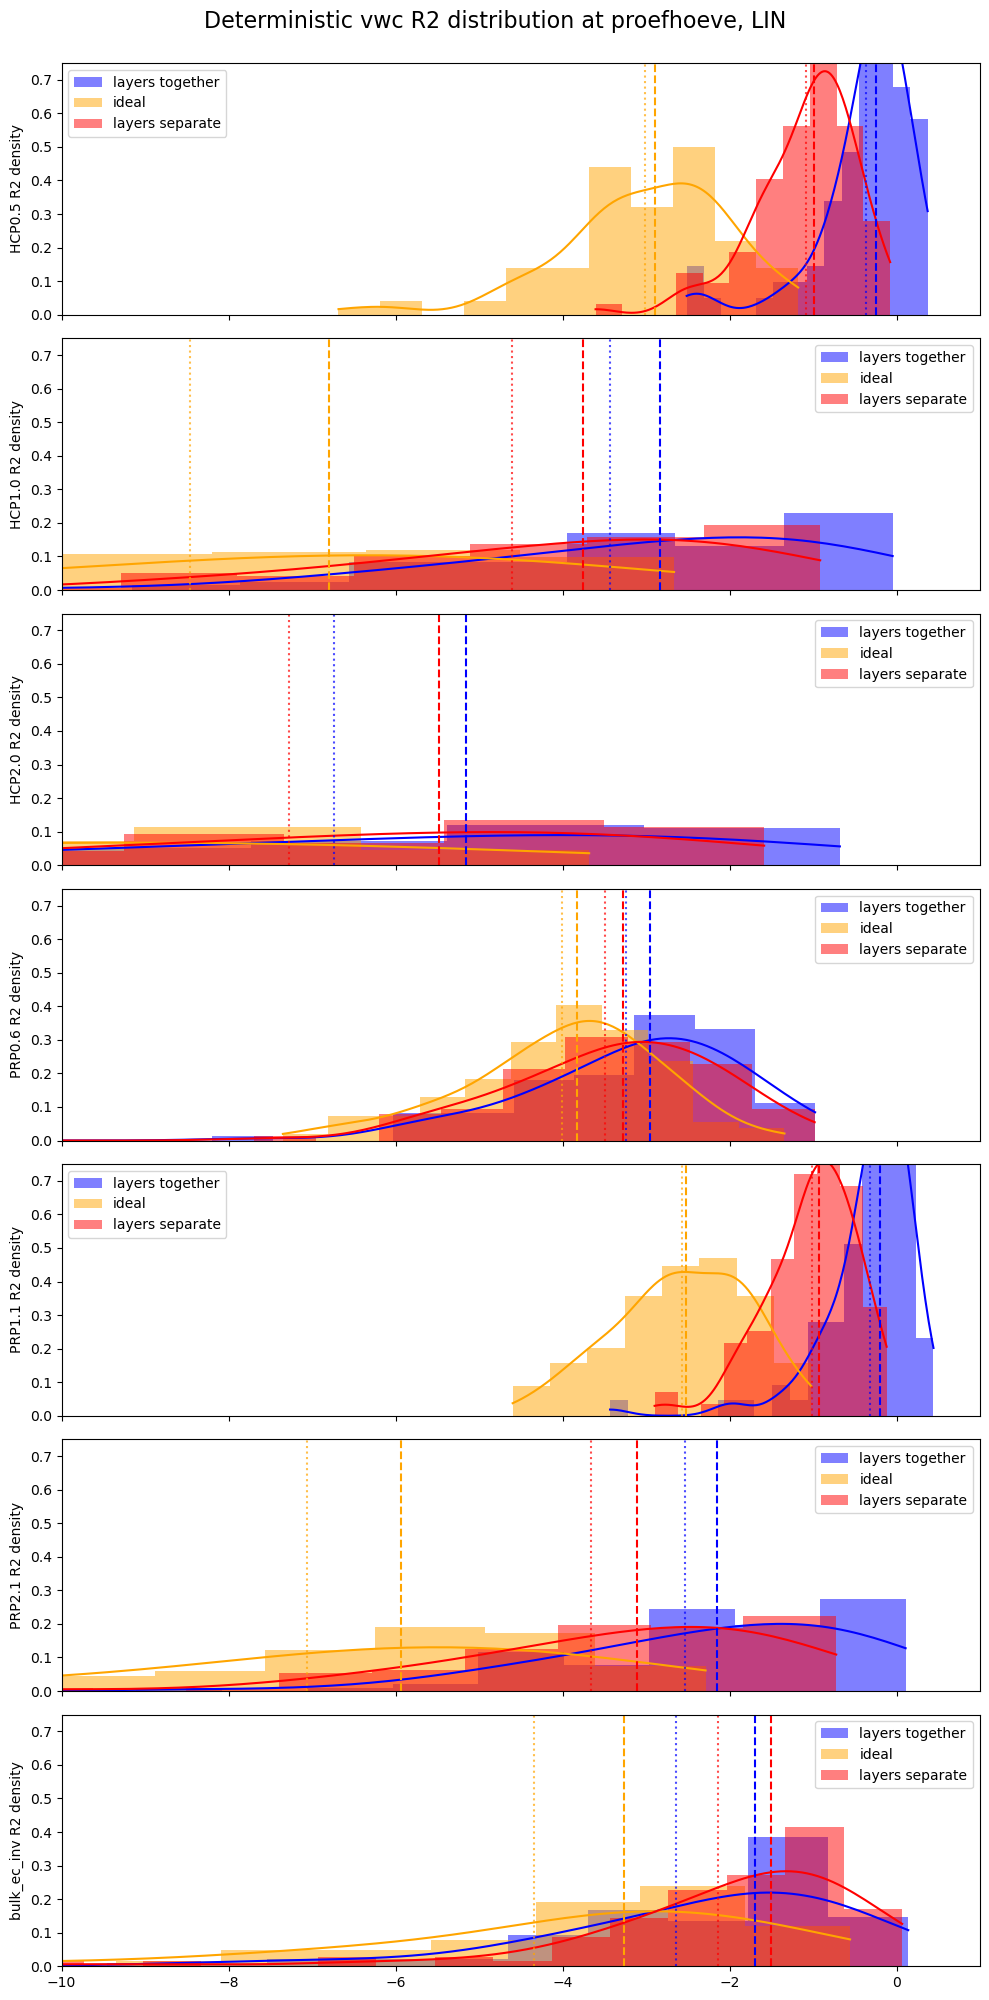

In [25]:
plot_det(Dresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'orange')

# Stochastic modelling

## Implementation

In [26]:
def stochastic(features, target, df, criteria='R2', n=4, iters=100, round_n=3):
    ### Defining lists to store results and error indicators
    SR2_train_10_, SR2_test_10_, Sypred_test_10_ = [], [], []
    SR2_train_50_, SR2_test_50_, Sypred_test_50_ = [], [], []
    SR2_train_LT_, SR2_test_LT_ = [], []
    SR2_train_LS_, SR2_test_LS_ = [], []
    y_test_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, features].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, features].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        SR2_train_10, SR2_test_10, Sypred_test_10 = [], [], []
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        SR2_train_50, SR2_test_50, Sypred_test_50 = [], [], []
        ### Combine test indices from both layers
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_train = np.concatenate((X_train10, X_train50))
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_test_.append(y_test)

        SR2_train_LS, SR2_test_LS = [], []
        SR2_train_LT, SR2_test_LT = [], []

        for k in range(n):

            #### Stochastic modelling for layers together
            polyLT = PolynomialFeatures(degree=k)
            polyLT.fit(X_train)
            Xt_trainLT = polyLT.transform(X_train)
            Xt_testLT = polyLT.transform(X_test.reshape(-1, 1))
            LinRegLT = LinearRegression()
            LinRegLT.fit(Xt_trainLT, y_train)
            Sypred_trainLT = LinRegLT.predict(Xt_trainLT)
            Sypred_testLT = LinRegLT.predict(Xt_testLT)
                # Save results and error indicators over polinomial degrees
            SR2_train_LT.append(round(r2_score(y_train, Sypred_trainLT), round_n))
            SR2_test_LT.append(round(r2_score(y_test, Sypred_testLT), round_n))

            #### Stochastic modelling 10 cm layer
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)
            LinReg10.fit(Xt_train10, y_train10)
            Sypred_train10 = LinReg10.predict(Xt_train10)
            Sypred_test10 = LinReg10.predict(Xt_test10)
                # Save results and error indicators over polinomial degrees
            Sypred_test_10.append(Sypred_test10)
            SR2_train_10.append(round(r2_score(y_train10, Sypred_train10), round_n))
            SR2_test_10.append(round(r2_score(y_test10, Sypred_test10), round_n))

            #### Stochastic modelling 50 cm layer
            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)
            LinReg50.fit(Xt_train50, y_train50)
            Sypred_train50 = LinReg50.predict(Xt_train50)
            Sypred_test50 = LinReg50.predict(Xt_test50)
                # Save results and error indicators over polinomial degrees
            Sypred_test_50.append(Sypred_test50)
            SR2_train_50.append(round(r2_score(y_train50, Sypred_train50), round_n))
            SR2_test_50.append(round(r2_score(y_test50, Sypred_test50), round_n))

            ### Stochastic modelling for layers separate. 
            ### This is a combination of both layer's prediction
            Sypred_train_LS = np.concatenate((Sypred_train10, Sypred_train50))
            Sypred_test_LS = np.concatenate((Sypred_test10, Sypred_test50))

            SR2_train_LS.append(round(r2_score(y_train, Sypred_train_LS), round_n))
            SR2_test_LS.append(round(r2_score(y_test, Sypred_test_LS), round_n))

        # Save results over all splits
        SR2_train_10_.append(SR2_train_10)
        SR2_test_10_.append(SR2_test_10)
        Sypred_test_10_.append(Sypred_test_10)

        SR2_train_50_.append(SR2_train_50)
        SR2_test_50_.append(SR2_test_50)
        Sypred_test_50_.append(Sypred_test_50)

        SR2_train_LS_.append(SR2_train_LS)
        SR2_test_LS_.append(SR2_test_LS)

        SR2_train_LT_.append(SR2_train_LT)
        SR2_test_LT_.append(SR2_test_LT)

        SR2_test_LS0 = [inner_list[0] for inner_list in SR2_test_LS_]
        SR2_test_LS1 = [inner_list[1] for inner_list in SR2_test_LS_]
        SR2_test_LS2 = [inner_list[2] for inner_list in SR2_test_LS_]
        SR2_test_LS3 = [inner_list[3] for inner_list in SR2_test_LS_]

        SR2_test_LT0 = [inner_list[0] for inner_list in SR2_test_LT_]
        SR2_test_LT1 = [inner_list[1] for inner_list in SR2_test_LT_]
        SR2_test_LT2 = [inner_list[2] for inner_list in SR2_test_LT_]
        SR2_test_LT3 = [inner_list[3] for inner_list in SR2_test_LT_]
        #####

        SR2_test_10_0 = [inner_list[0] for inner_list in SR2_test_10_]
        SR2_test_10_1 = [inner_list[1] for inner_list in SR2_test_10_]
        SR2_test_10_2 = [inner_list[2] for inner_list in SR2_test_10_]
        SR2_test_10_3 = [inner_list[3] for inner_list in SR2_test_10_]

        SR2_test_50_0 = [inner_list[0] for inner_list in SR2_test_50_]
        SR2_test_50_1 = [inner_list[1] for inner_list in SR2_test_50_]
        SR2_test_50_2 = [inner_list[2] for inner_list in SR2_test_50_]
        SR2_test_50_3 = [inner_list[3] for inner_list in SR2_test_50_]

    #########################
    if criteria == 'R2':

        SR2_10 = [SR2_test_10_0, SR2_test_10_1, SR2_test_10_2, SR2_test_10_3]
        SR2_meadian_10 = [np.median(sublist) for sublist in SR2_10]
        best_n_10 = SR2_meadian_10.index(np.max(SR2_meadian_10))
        SR2_test_10b = SR2_10[best_n_10]

        SR2_50 = [SR2_test_50_0, SR2_test_50_1, SR2_test_50_2, SR2_test_50_3]
        SR2_meadian_50 = [np.median(sublist) for sublist in SR2_50]
        best_n_50 = SR2_meadian_50.index(np.max(SR2_meadian_50))
        SR2_test_50b = SR2_50[best_n_50]

        SR2_LT = [SR2_test_LT0, SR2_test_LT1, SR2_test_LT2, SR2_test_LT3]
        SR2_meadian_LT = [np.median(sublist) for sublist in SR2_LT]
        best_n_LT = SR2_meadian_LT.index(np.max(SR2_meadian_LT))
        SR2_test_LTb = SR2_LT[best_n_LT]

        SR2_LS = [SR2_test_LS0, SR2_test_LS1, SR2_test_LS2, SR2_test_LS3]
        SR2_meadian_LS = [np.median(sublist) for sublist in SR2_LS]
        best_n_LS = SR2_meadian_LS.index(np.max(SR2_meadian_LS))
        SR2_test_LSb = SR2_LS[best_n_LS]

        ### Based on the best dgrees per layer, make up the LS2 model, the one that uses models for layer which are not necesarely equal. 
        SR2_test_LS2b = []
        for j in range(iters):
            Sypred_test_10b = [inner_list[best_n_10] for inner_list in Sypred_test_10_][j]
            Sypred_test_50b = [inner_list[best_n_50] for inner_list in Sypred_test_50_][j]

            Sypred_LS2b = np.concatenate((Sypred_test_10b, Sypred_test_50b))
            SR2_test_LS2b.append(round(r2_score(y_test_[j], Sypred_LS2b), round_n))

        best_n_LS2 = [best_n_10, best_n_50]
    best_ns = [best_n_LT, best_n_LS, best_n_LS2]
    return SR2_test_LTb, SR2_test_LSb, SR2_test_LS2b, SR2_test_10b, SR2_test_50b, best_ns

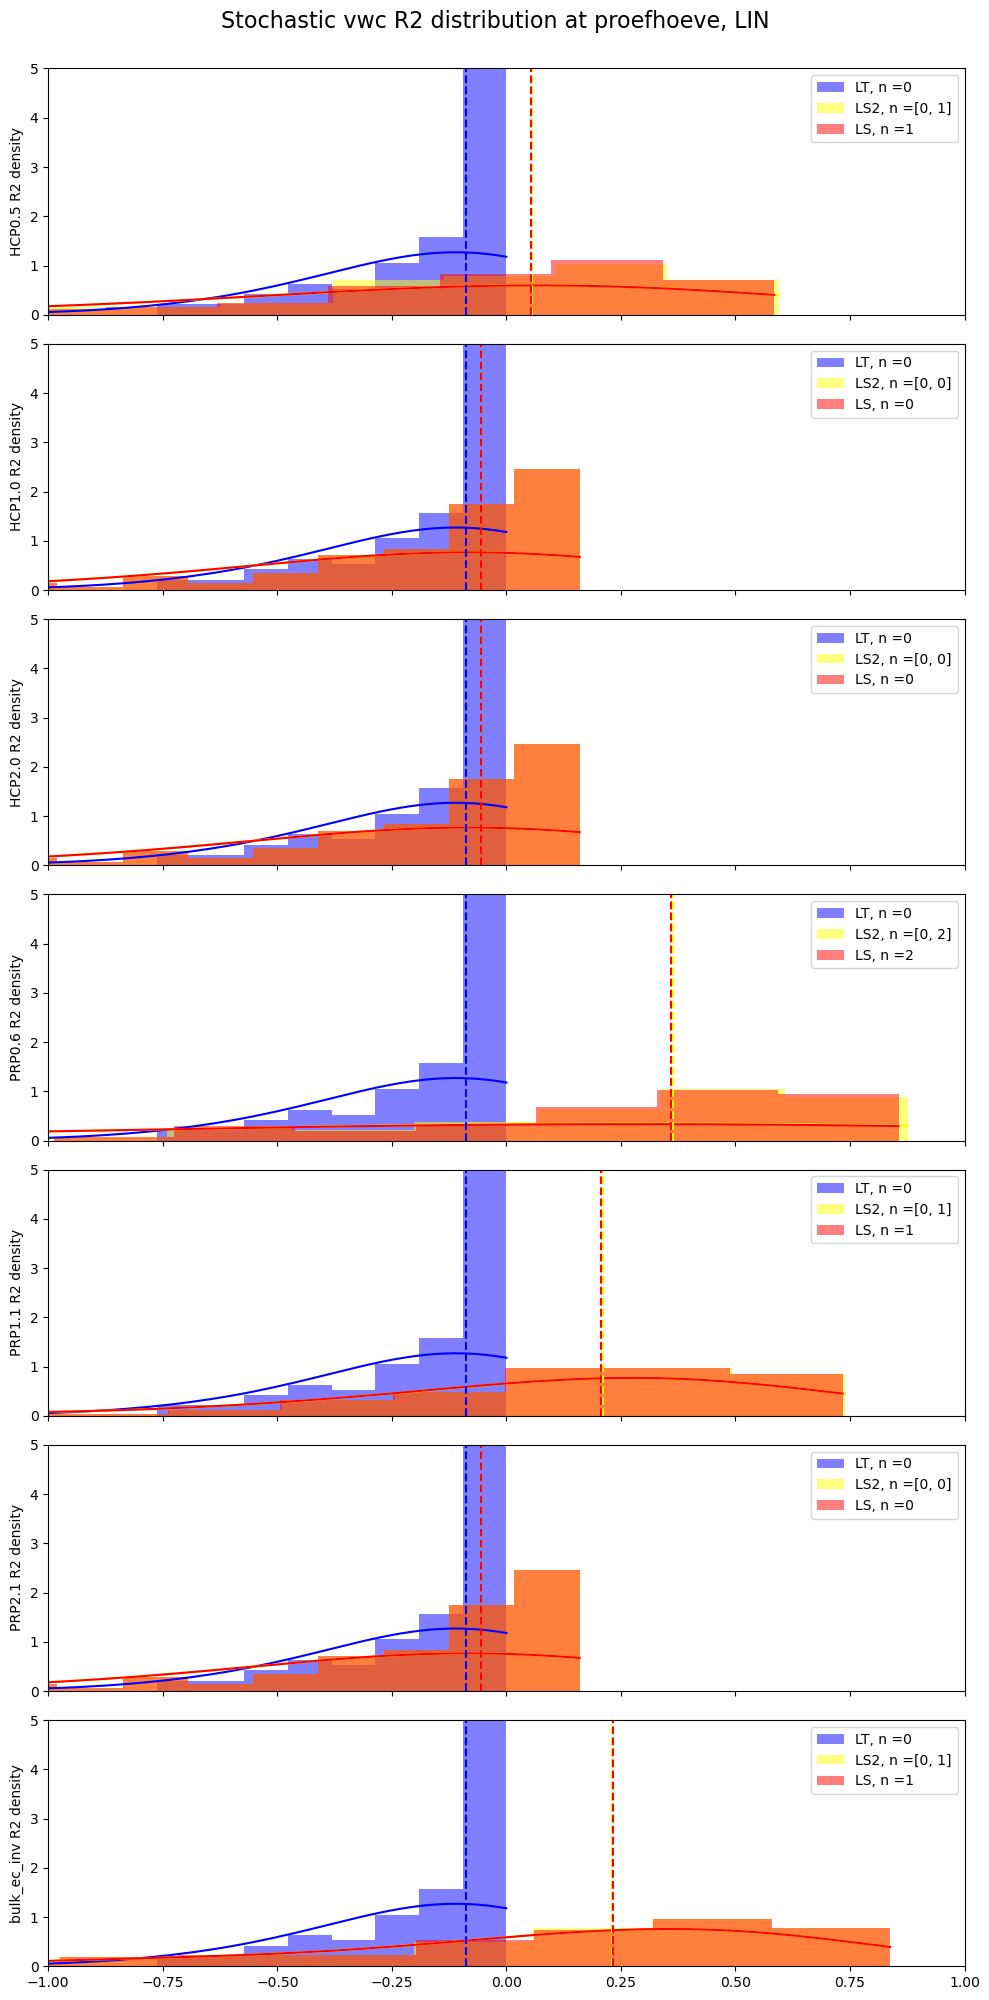

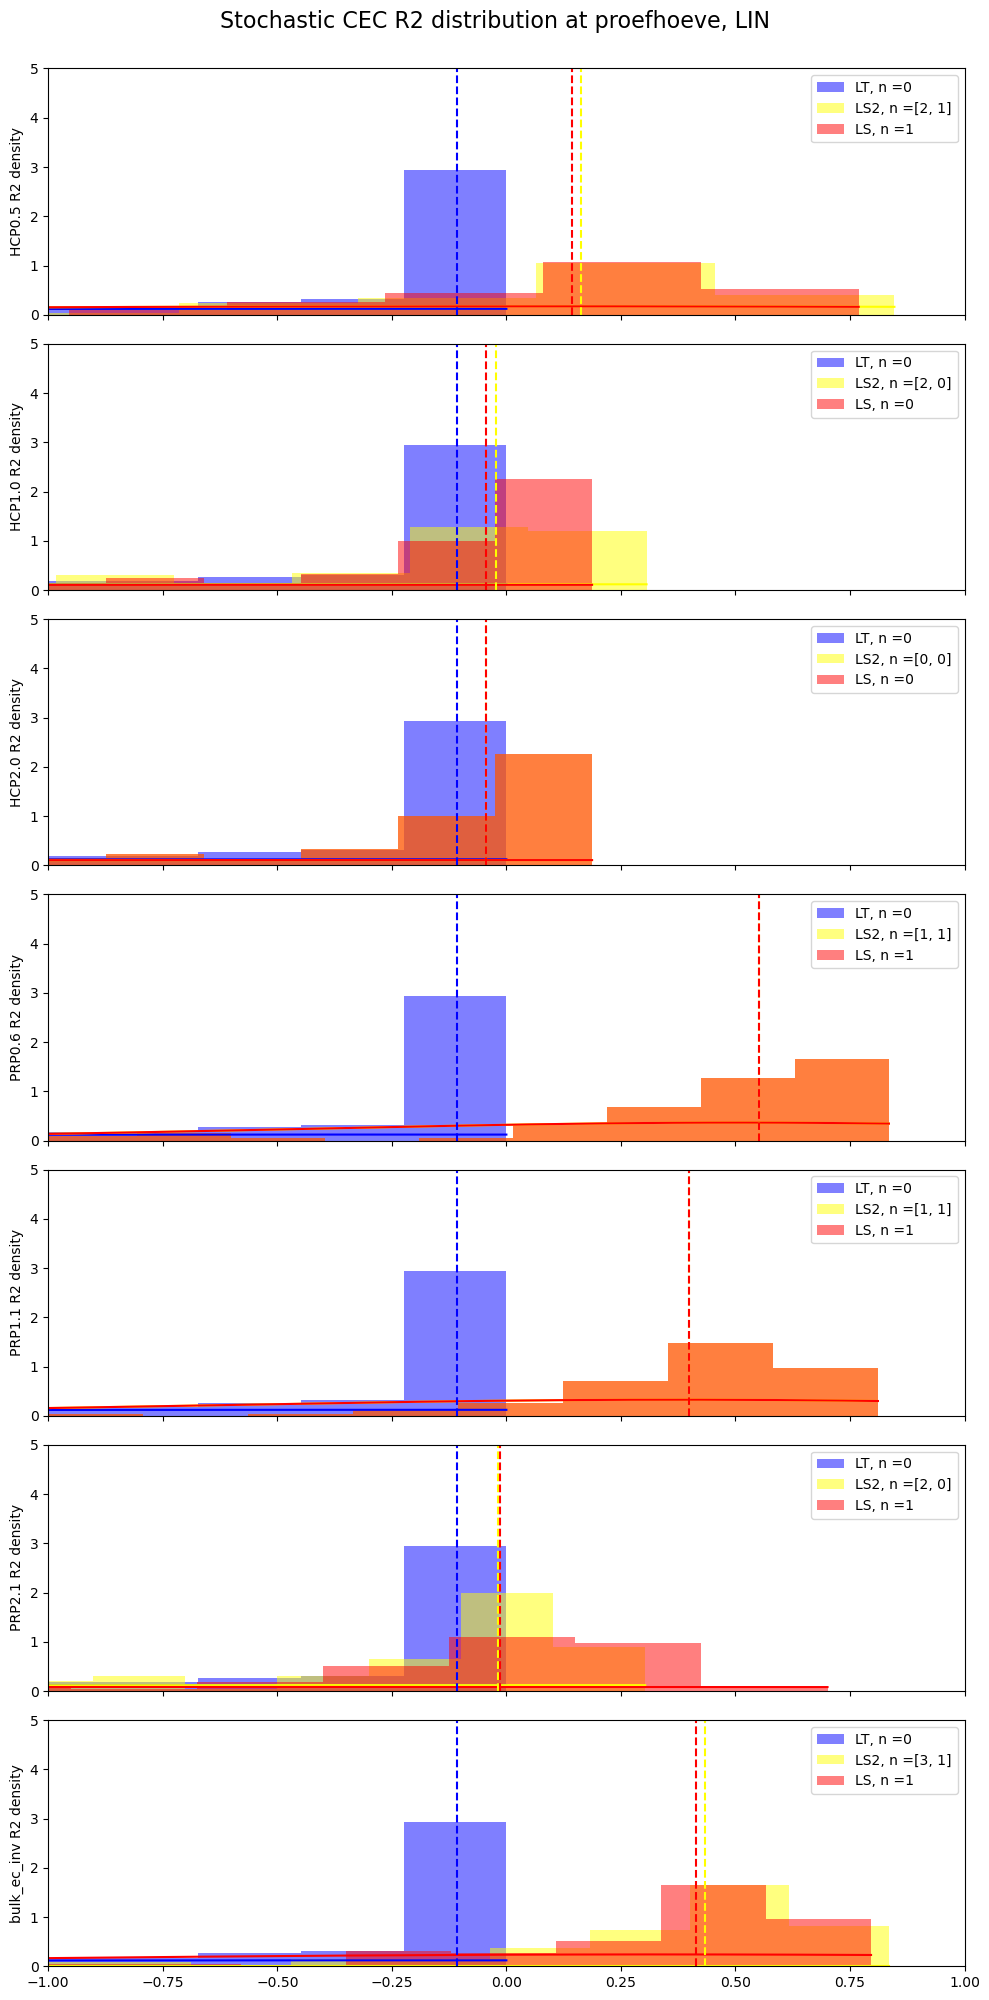

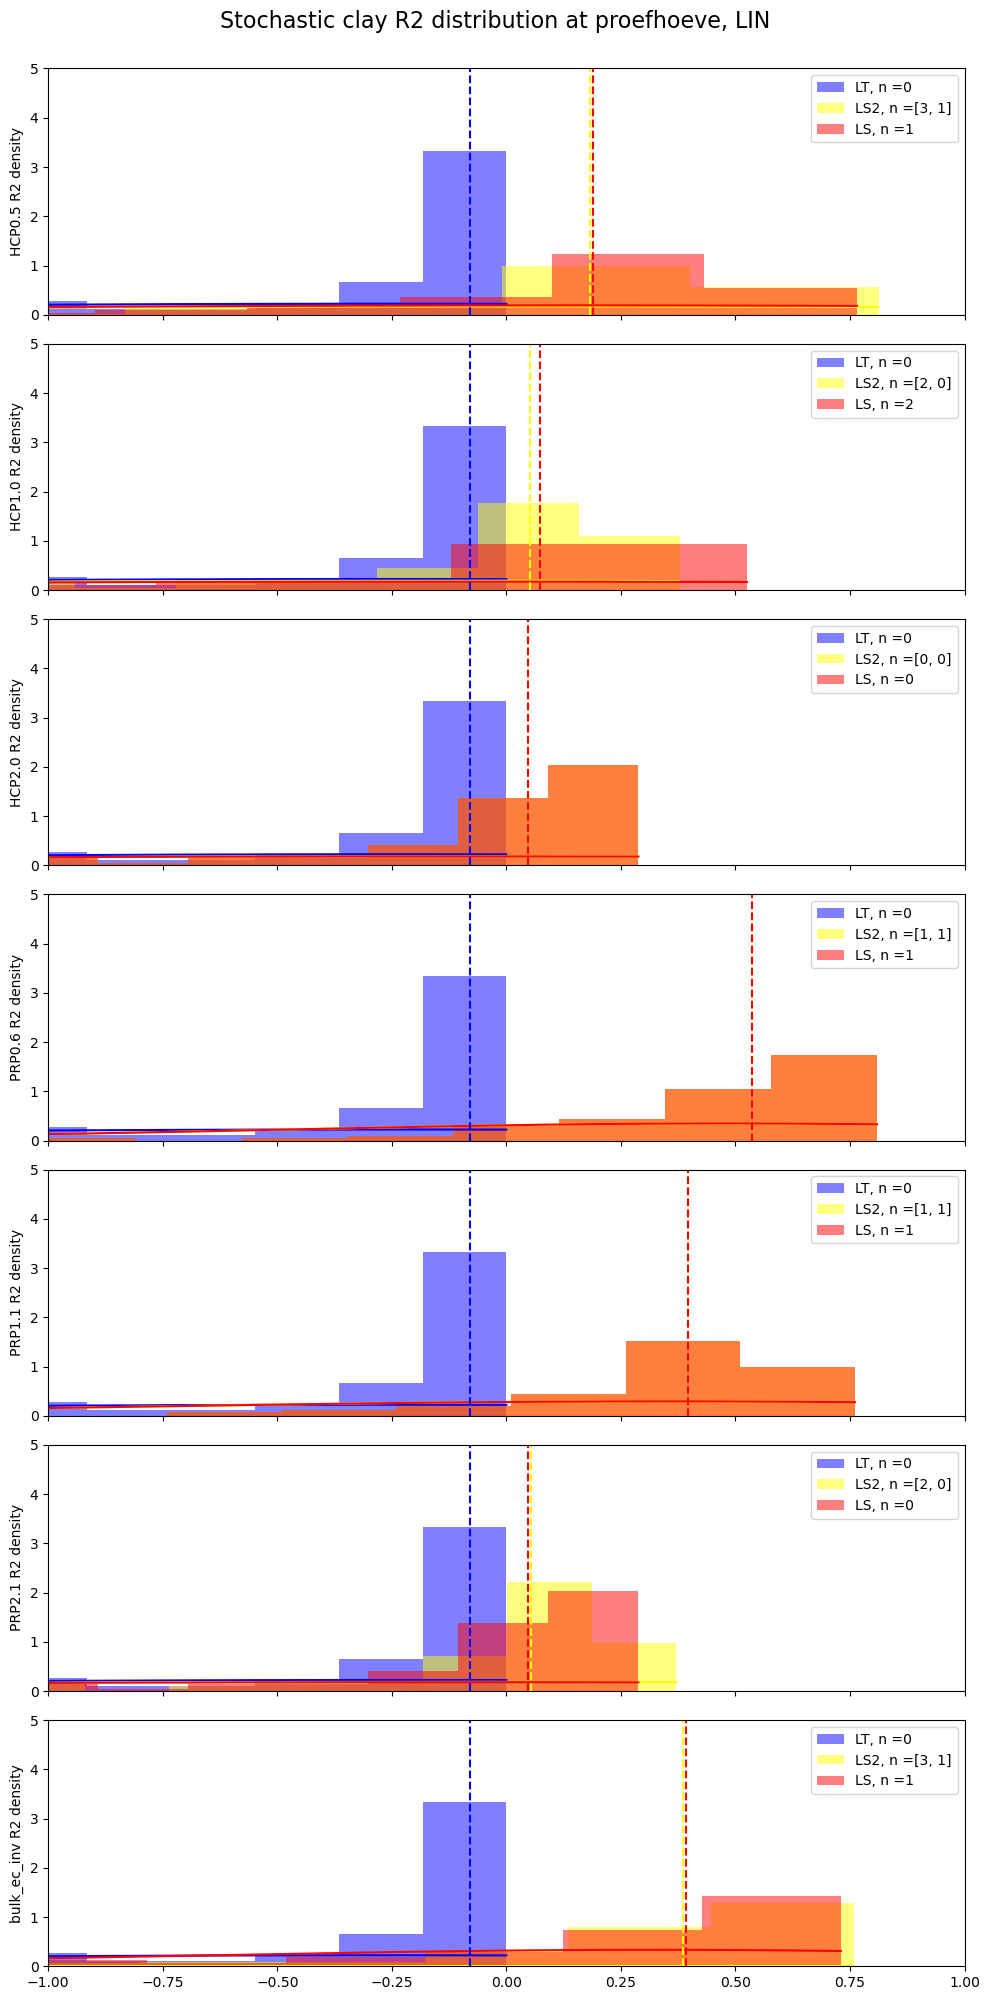

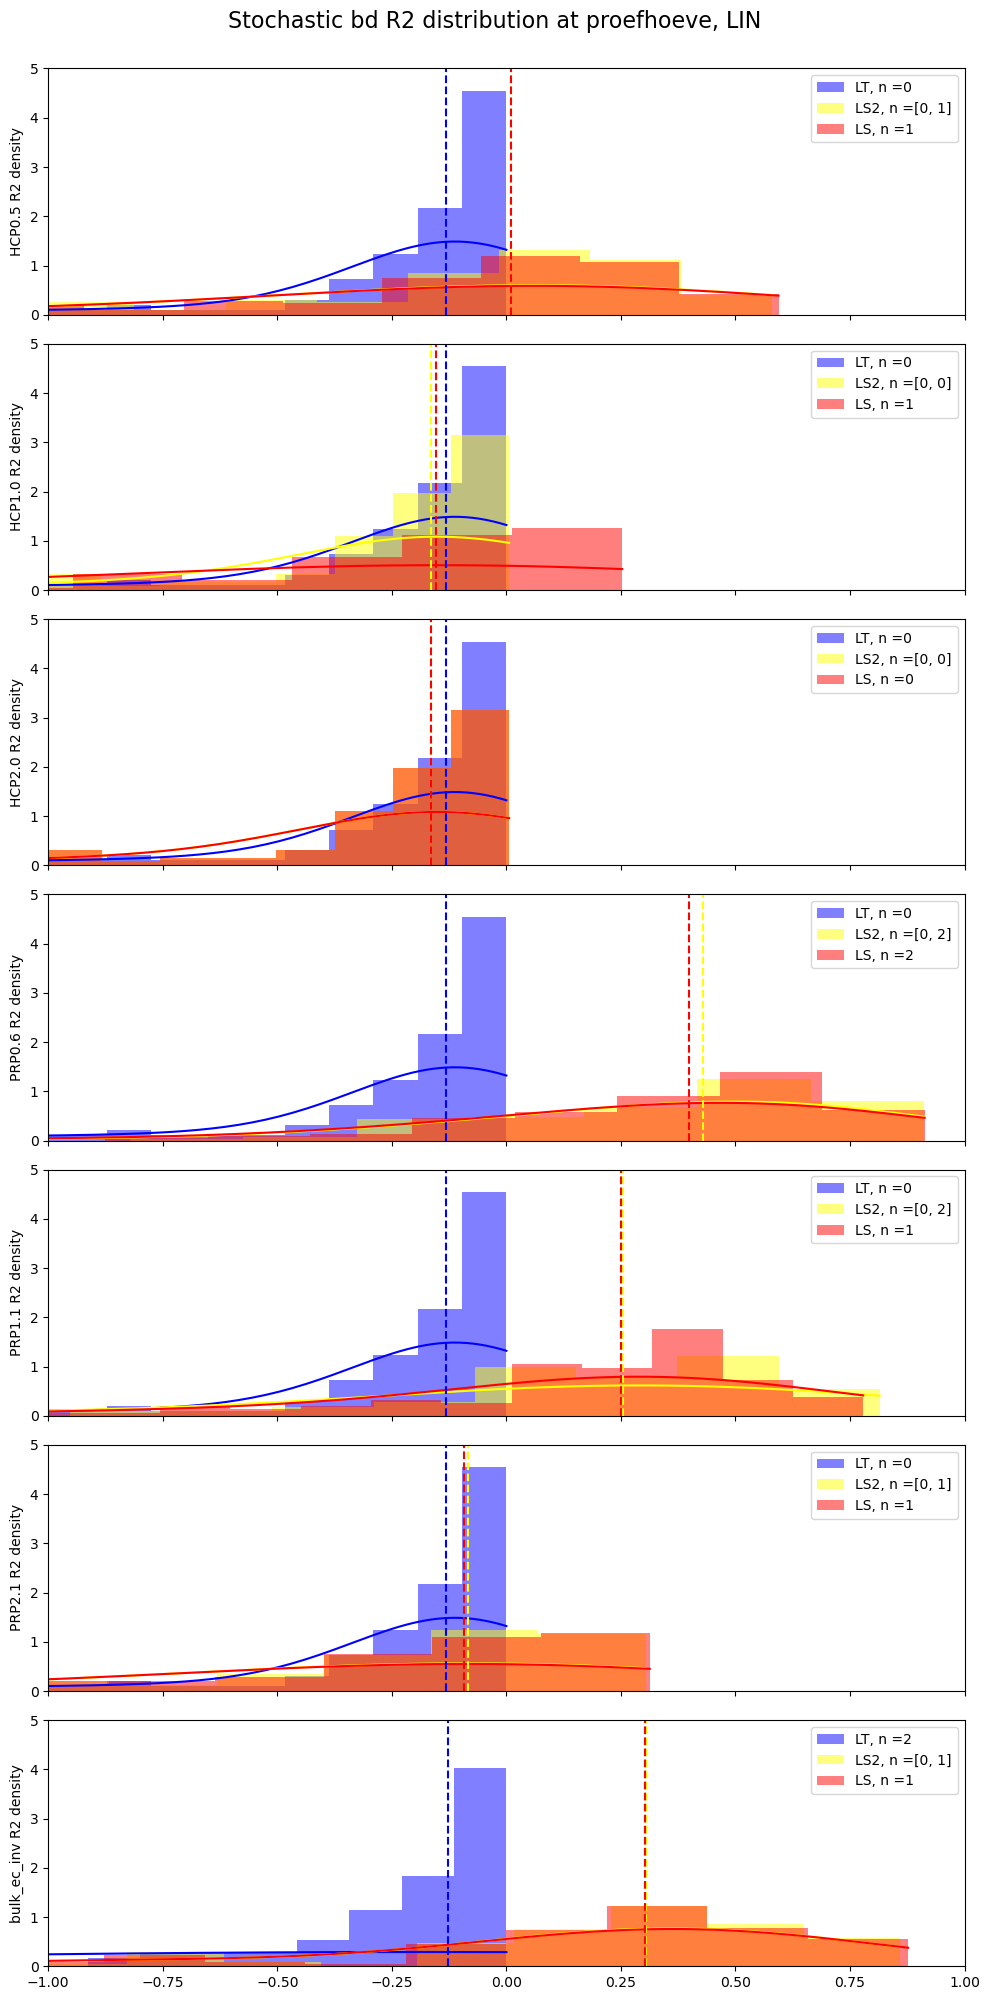

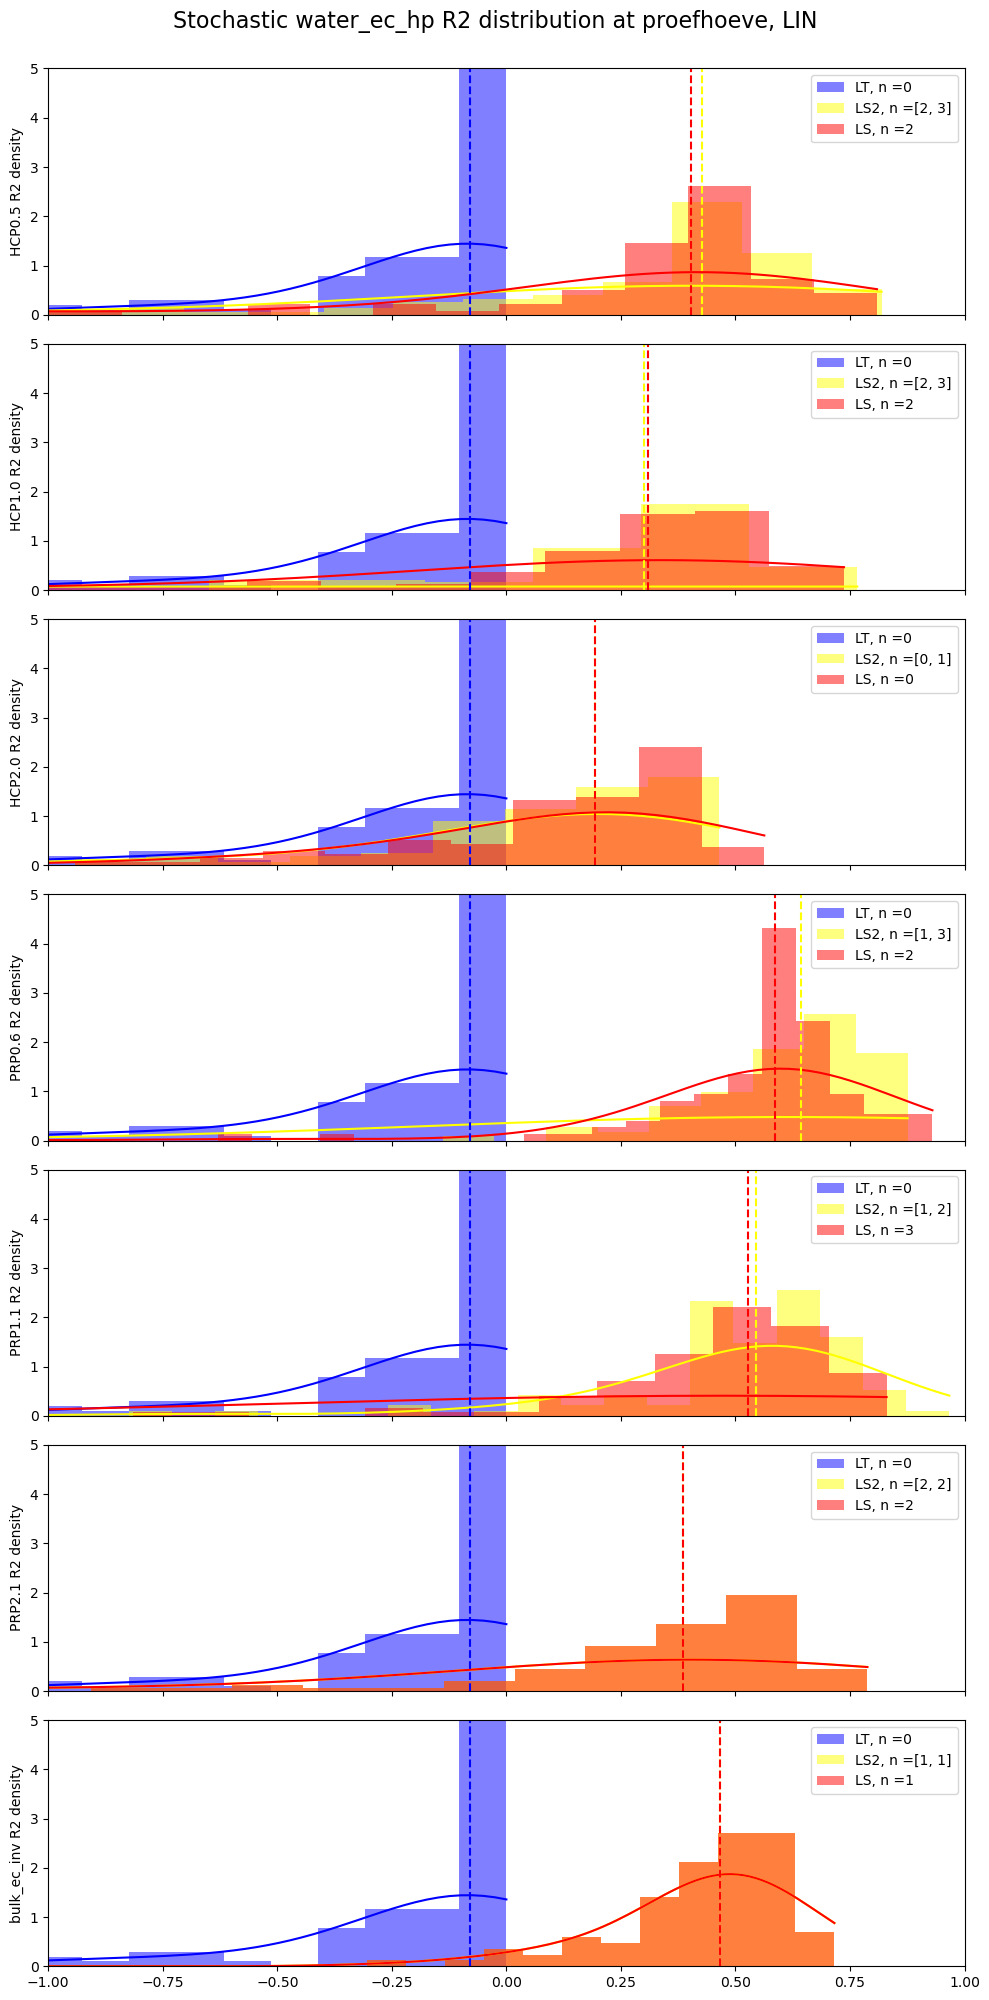

In [27]:
###########################
#### Store results ########
feature_set = [
    'HCP0.5',
    'HCP1.0',
    'HCP2.0',
    'PRP0.6',
    'PRP1.1',
    'PRP2.1',
    'bulk_ec_inv',
]

target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]

Sresults = {}
SR2_results = pd.DataFrame(columns=['Target', 'Best Feature LT', 'R2 LT', 'Best Feature LS', 'R2 LS', 'Best Feature LS2', 'R2 LS2'
                               , 'Best Feature 10', 'R2 10', 'Best Feature 50', 'R2 50'])

for i, target in enumerate(target_set):
    max_r2_lt = -float('inf')
    max_r2_ls = -float('inf')
    max_r2_ls2 = -float('inf')
    max_r2_10 = -float('inf')
    max_r2_50 = -float('inf')
    best_feature_lt = None
    best_feature_ls = None
    best_feature_ls2 = None

    for feature in feature_set:
        SR2_test_LT, SR2_test_LS, SR2_test_LS2, SR2_test_10, SR2_test_50, best_ns = stochastic(feature, target, ds_c)

        Sresults[feature] = {
            'LT': {'R2': SR2_test_LT, 'n': best_ns[0]},
            'LS': {'R2': SR2_test_LS, 'n': best_ns[1]},
            'LS2': {'R2': SR2_test_LS2, 'n': best_ns[2]},
            '10': {'R2': SR2_test_10, 'n': best_ns[2]},
            '50': {'R2': SR2_test_50, 'n': best_ns[2]}
        }

    for feature, result in Sresults.items():
        if np.median(result['LT']['R2']) > max_r2_lt:
            max_r2_lt = np.median(result['LT']['R2'])
            best_feature_lt = feature

        if np.median(result['LS']['R2']) > max_r2_ls:
            max_r2_ls = np.median(result['LS']['R2'])
            best_feature_ls = feature

        if np.median(result['LS2']['R2']) > max_r2_ls2:
            max_r2_ls2 = np.median(result['LS2']['R2'])
            best_feature_ls2 = feature

        if np.median(result['10']['R2']) > max_r2_10:
            max_r2_10 = np.median(result['10']['R2'])
            best_feature_10 = feature

        if np.median(result['50']['R2']) > max_r2_50:
            max_r2_50 = np.median(result['50']['R2'])
            best_feature_50 = feature

    SR2_results.loc[i, 'Target'] = target
    SR2_results.loc[i, 'Best Feature LT'] = best_feature_lt
    SR2_results.loc[i, 'R2 LT'] = max_r2_lt
    SR2_results.loc[i, 'Best Feature LS'] = best_feature_ls
    SR2_results.loc[i, 'R2 LS'] = max_r2_ls
    SR2_results.loc[i, 'Best Feature LS2'] = best_feature_ls2
    SR2_results.loc[i, 'R2 LS2'] = max_r2_ls2
    SR2_results.loc[i, 'Best Feature 10'] = best_feature_10
    SR2_results.loc[i, 'R2 10'] = max_r2_10
    SR2_results.loc[i, 'Best Feature 50'] = best_feature_50
    SR2_results.loc[i, 'R2 50'] = max_r2_50

    plot_stoch(Sresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'yellow')
    #Sresults.to_csv('Sresults_'+target+'.csv', index=False)

    #feature HCP0.5 target vwc
#y_train [0.28979 0.27    0.27103 0.2534  0.25825 0.26763 0.26113 0.27619 0.30258
# 0.23165 0.46804 0.47371 0.14206 0.21031 0.15773 0.16165 0.23969 0.40361
# 0.45196 0.40536]
#y_train [0.28979 0.25845 0.27103 0.27619 0.27536 0.27443 0.25897 0.23165 0.26763
# 0.30258 0.46804 0.25845 0.14206 0.40361 0.30856 0.48412 0.30722 0.40536
# 0.16165 0.45196]

In [28]:
SR2_results.to_excel('SR2_results'+'_'+s_site+'_'+em_intype+'_'+cal+'_'+instrument_code+'.xlsx', index=False)
SR2_results

,Target,Best Feature LT,R2 LT,Best Feature LS,R2 LS,Best Feature LS2,R2 LS2,Best Feature 10,R2 10,Best Feature 50,R2 50
0,vwc,HCP0.5,-0.088,PRP0.6,0.3595,PRP0.6,0.3635,HCP0.5,-0.2645,PRP0.6,0.268
1,CEC,HCP0.5,-0.1075,PRP0.6,0.5525,PRP0.6,0.5525,bulk_ec_inv,0.6675,PRP0.6,0.494
2,clay,HCP0.5,-0.08,PRP0.6,0.5365,PRP0.6,0.5365,bulk_ec_inv,0.552,PRP0.6,0.405
3,bd,bulk_ec_inv,-0.128,PRP0.6,0.3995,PRP0.6,0.4285,HCP0.5,-0.205,PRP0.6,0.434
4,water_ec_hp,HCP0.5,-0.08,PRP0.6,0.587,PRP0.6,0.6425,PRP0.6,0.5025,PRP0.6,0.384
